In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import least_squares
import xarray as xr

from src.spatial_axis import SpatialAxis, spatial_axis_defn_dict

In [2]:
ds = xr.open_dataset(os.path.join(os.getenv("HOME"), "test_run_phosphorus_wdir", "iterate_02.nc"))
ds

<xarray.Dataset>
Dimensions:       (depth: 30, depth_edges: 31, nbnds: 2)
Coordinates:
  * depth         (depth) float64 5.0 15.01 25.07 35.32 ... 775.1 825.0 875.0
  * depth_edges   (depth_edges) float64 0.0 10.0 20.02 ... 800.0 850.0 900.0
Dimensions without coordinates: nbnds
Data variables:
    depth_bounds  (depth, nbnds) float64 ...
    depth_delta   (depth) float64 ...
    po4           (depth) float64 ...
    dop           (depth) float64 ...
    pop           (depth) float64 ...
    po4_s         (depth) float64 ...
    dop_s         (depth) float64 ...
    pop_s         (depth) float64 ...
Attributes:
    history:  2021-02-22 10:12:43: created by src.test_problem.model_state.Mo...

In [3]:
def penalty(fit_coeffs):
    weight = ds["depth_delta"].values[:]
    weight = weight / weight.sum()
    var_approx = np.interp(ds["depth"].values[:], 100.0 * np.cumsum(fit_coeffs[:2]), fit_coeffs[2:])
    truth = ds[varname].values[:]
    anom_relative = (var_approx - ds[varname].values[:]) / truth.max()
    return np.sqrt((weight * anom_relative * anom_relative).sum())

def penalty_fixed_nodes(fit_coeffs):
    weight = ds["depth_delta"].values[:]
    weight = weight / weight.sum()
    var_approx = np.interp(ds["depth"].values[:], 100.0 * np.cumsum(fixed_nodes[:]), fit_coeffs[:])
    truth = ds[varname].values[:]
    anom_relative = (var_approx - ds[varname].values[:]) / truth.max()
    return np.sqrt((weight * anom_relative * anom_relative).sum())

In [4]:
init_vals = {}
init_vals["po4"] = {"shallow": 0.1, "deep": 4.0}
init_vals["dop"] = {"shallow": 0.07, "deep": 0.01}
init_vals["pop"] = {"shallow": 0.02, "deep": 0.002}

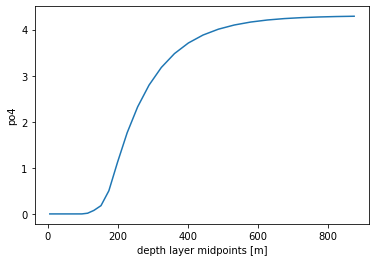

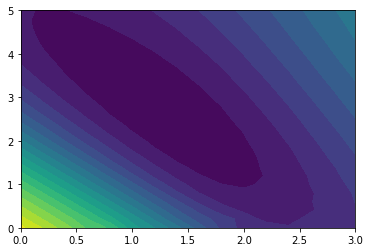

[1.4 2.4 0.1 4. ]
 active_mask: array([0, 0, 0, 0])
        cost: 0.0007675068575757072
         fun: array([0.03917925])
        grad: array([ 3.59965203e-09, -9.44279149e-09,  1.73183643e-06, -5.57861648e-09])
         jac: array([[ 9.18764890e-08, -2.41015109e-07,  4.42028977e-05,
        -1.42387012e-07]])
     message: '`gtol` termination condition is satisfied.'
        nfev: 2624
        njev: 2243
  optimality: 9.46220405814011e-09
      status: 1
     success: True
           x: array([1.27215335, 2.58512755, 0.00546368, 4.14031577])
****************************************


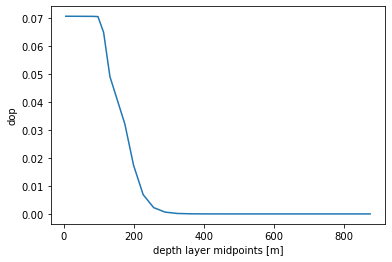

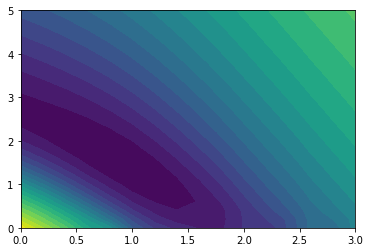

[1.   1.4  0.07 0.01]
 active_mask: array([0, 0, 0, 0])
        cost: 8.789770835985966e-05
         fun: array([0.01325879])
        grad: array([ 2.43798370e-07, -3.53438610e-07,  1.20933401e-06,  2.09972772e-06])
         jac: array([[ 1.83876837e-05, -2.66569352e-05,  9.12100077e-05,
         1.58365001e-04]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 4051
        njev: 3146
  optimality: 3.534386104240332e-07
      status: 3
     success: True
           x: array([9.46347457e-01, 1.41996292e+00, 7.05058027e-02, 1.51110401e-04])
****************************************


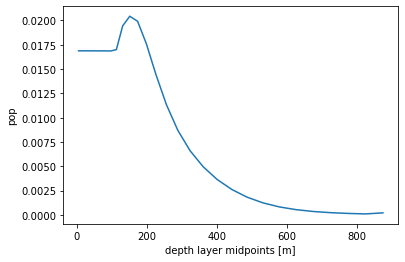

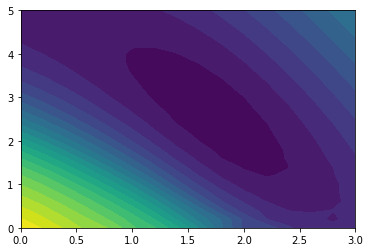

[1.8e+00 2.4e+00 2.0e-02 2.0e-03]
 active_mask: array([0, 0, 0, 0])
        cost: 0.001250706690461329
         fun: array([0.05001413])
        grad: array([-3.06962283e-05, -1.62419300e-04,  2.25815466e-04,  2.47794556e-04])
         jac: array([[-0.00061375, -0.00324747,  0.00451503,  0.00495449]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 8782
        njev: 6579
  optimality: 0.00016241930002215183
      status: 3
     success: True
           x: array([1.73830384e+00, 2.48004829e+00, 1.78828303e-02, 7.93003906e-04])
****************************************


In [5]:
for varname in ["po4", "dop", "pop"]:
    ds[varname].plot()
    plt.show()

    h1_vals = np.linspace(0.0, 3.0, 16)
    h2_vals = np.linspace(0.0, 5.0, 26)

    fit_coeffs_0 = np.array([init_vals[varname]["shallow"], init_vals[varname]["deep"]])

    bounds = ( np.array([0.0, 0.0]), np.array([np.inf, np.inf]) )

    res = np.zeros((len(h2_vals), len(h1_vals)))

    for i1, x1 in enumerate(h1_vals):
        for i2, x2 in enumerate(h2_vals):
            fixed_nodes = np.array([x1, x2])
            res[i2, i1] = least_squares(penalty_fixed_nodes, fit_coeffs_0, bounds=bounds, max_nfev=10000, ftol=1.0e-10).cost

    plt.contourf(h1_vals, h2_vals, res, 20)
    plt.show()

    ind = np.unravel_index(np.argmin(res, axis=None), res.shape)

    fit_coeffs_0 = np.array(
        [h1_vals[ind[1]],
         h2_vals[ind[0]],
         init_vals[varname]["shallow"],
         init_vals[varname]["deep"]]
    )
    print(fit_coeffs_0)

    bounds = ( np.array([0.0, 0.0, 0.0, 0.0]), np.array([np.inf, np.inf, np.inf, np.inf]) )
    res = least_squares(penalty, fit_coeffs_0, bounds=bounds, max_nfev=10000, ftol=1.0e-10)
    print(res)
    print(40 * "*")